<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
#Start Here

from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

import spacy

import pandas as pd

In [2]:
%pwd

'C:\\Users\\Ryan\\DS-Unit-4-Sprint-1-NLP\\module4-topic-modeling'

In [3]:
df = pd.read_csv('./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [4]:
df.shape

(28332, 24)

In [5]:
# Subset to just one product or Category here

list(df)

['id',
 'dateAdded',
 'dateUpdated',
 'name',
 'asins',
 'brand',
 'categories',
 'primaryCategories',
 'imageURLs',
 'keys',
 'manufacturer',
 'manufacturerNumber',
 'reviews.date',
 'reviews.dateSeen',
 'reviews.didPurchase',
 'reviews.doRecommend',
 'reviews.id',
 'reviews.numHelpful',
 'reviews.rating',
 'reviews.sourceURLs',
 'reviews.text',
 'reviews.title',
 'reviews.username',
 'sourceURLs']

In [6]:
df['primaryCategories'].value_counts()

Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Electronics,Furniture              2
Home & Garden                      2
Name: primaryCategories, dtype: int64

In [7]:
df = df[df['primaryCategories'] == 'Electronics'].copy()

## Get Tokens

In [8]:
nlp = spacy.load("en_core_web_lg")

In [9]:
tokens = []

for doc in nlp.pipe(df['reviews.text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.lemma_.lower())
            
    tokens.append(doc_tokens)
        
df['tokens'] = tokens

del tokens

In [10]:
df['tokens'].head()

8343    [great, case, place, husband, love, hold, lot,...
8344    [discard, get, rid, broken, cd, case, broken, ...
8345                            [dollar, boycott, amazon]
8346    [initial, impression, good, material, nice, sh...
8347    [pro, standard, echo, con, old, generation, ec...
Name: tokens, dtype: object

# Create id2word


In [11]:
id2word = Dictionary(df['tokens'])
print(len(id2word))

6301


In [12]:
id2word.filter_extremes(no_below=5, no_above=.98)
print(len(id2word))

2162


## Create Corpus Object

In [13]:
corpus = [id2word.doc2bow(d) for d in df['tokens']]

In [14]:
model = LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, workers=12, passes=5)

In [15]:
import re
words = [re.findall(r'"([^"]*)"',t[1]) for t in model.print_topics()]

In [16]:
topics = [' '.join(t[0:5]) for t in words]

In [17]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
love easy buy use old

------ Topic 1 ------
great tablet price use kid

------ Topic 2 ------
fire buy game love use

------ Topic 3 ------
work great tablet kindle love

------ Topic 4 ------
good tablet amazon buy app

------ Topic 5 ------
tablet love great use like

------ Topic 6 ------
tablet kid good old use

------ Topic 7 ------
tablet good price amazon great

------ Topic 8 ------
great love tablet buy good

------ Topic 9 ------
read book kindle like great



In [19]:
# Steps to Score Training Documents
# Already have BOW Represented called 'corpus'

distro = [model[d] for d in corpus]
num_topics = 20

def update(doc):
        d_dist = {k:0 for k in range(0,num_topics)}
        for topic in doc:
            # Topic is Tuple where the first part is the topic id
            # the second part is the topic distribution in that doc
            d_dist[topic[0]] = topic[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [20]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.019406 -0.027813       1        1  13.510074
9      0.040930 -0.068035       2        1  11.628217
0     -0.118173  0.040493       3        1  10.297474
8      0.001490  0.014899       4        1   9.728559
7      0.086510  0.097863       5        1   9.621734
6     -0.023190 -0.020364       6        1   9.343909
3      0.011120  0.004172       7        1   9.078418
1     -0.009282 -0.015669       8        1   8.973615
5     -0.016178  0.015112       9        1   8.919960
4      0.046180 -0.040660      10        1   8.898047, topic_info=       Term         Freq        Total Category  logprob  loglift
515  tablet  6308.000000  6308.000000  Default  30.0000  30.0000
915     kid  1987.000000  1987.000000  Default  29.0000  29.0000
5      love  4552.000000  4552.000000  Default  28.0000  28.0000
1     great  4597.000000  4597.000000  Default  27.0000  27.0000
42     work  1575.000000  1575.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
90    price   116.941216  2019.231201  Topic10  -4.9529  -0.4295
800    game   108.793915  1504.933228  Topic10  -5.0251  -0.2077
685  kindle   119.345688  2452.035889  Topic10  -4.9325  -0.6033
16      get    95.269890  1299.172363  Topic10  -5.1578  -0.1934
5      love   102.244789  4552.905762  Topic10  -5.0872  -1.3768

[796 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
942       1  0.137817       $
942       2  0.029532       $
942       3  0.027071       $
942       4  0.091057       $
942       5  0.265789       $
...     ...       ...     ...
429       5  0.730382  zipper
429       6  0.060865  zipper
429       9  0.060865  zipper
2015      1  0.815337       ©
2015      4  0.101917       ©

[3098 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 10, 1, 9, 8, 7, 4, 2, 6, 5])

In [21]:
list(df)

['id',
 'dateAdded',
 'dateUpdated',
 'name',
 'asins',
 'brand',
 'categories',
 'primaryCategories',
 'imageURLs',
 'keys',
 'manufacturer',
 'manufacturerNumber',
 'reviews.date',
 'reviews.dateSeen',
 'reviews.didPurchase',
 'reviews.doRecommend',
 'reviews.id',
 'reviews.numHelpful',
 'reviews.rating',
 'reviews.sourceURLs',
 'reviews.text',
 'reviews.title',
 'reviews.username',
 'sourceURLs',
 'tokens']

In [22]:
# How are topics correlated with rating? 

topics = pd.DataFrame.from_records(new_distro)
topics.head()

#topics['primaryTopic'] = topics.idxmax(axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.012503,0.012503,0.012504,0.012504,0.012503,0.012507,0.012503,0.012503,0.887466,0.012504,0,0,0,0,0,0,0,0,0,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.824186,0.159804,0,0,0,0,0,0,0,0,0,0
2,0.033337,0.033337,0.033339,0.033341,0.033347,0.033337,0.033340,0.699942,0.033340,0.033340,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.495581,0.256967,0.000000,0.240905,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000000,0.000000,0.505942,0.000000,0.000000,0.432489,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0


In [23]:
df['primaryTopic'] = topics.idxmax(axis=1)

In [24]:
df[['primaryTopic', 'reviews.rating']].groupby('primaryTopic').mean()

,reviews.rating
primaryTopic,
0.0,4.563025
1.0,4.605634
2.0,4.619048
3.0,4.568966
4.0,4.651685
5.0,4.576720
6.0,4.570000
7.0,4.572727
8.0,4.590909


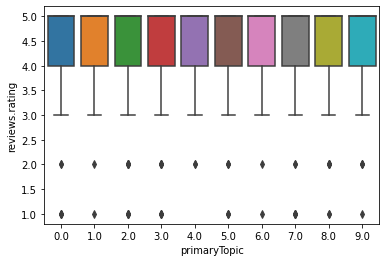

In [25]:
import seaborn as sns

ax = sns.boxplot(x="primaryTopic", y="reviews.rating",
                 data=df)

In [26]:
# Are certin topics more helpful?

df['reviews.numHelpful'].describe()

count    13866.000000
mean         0.552430
std         10.034626
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        621.000000
Name: reviews.numHelpful, dtype: float64

In [27]:
# Continuous Variable

# Bin - using boxplot of upvotes per topic? 

topics_df = pd.DataFrame.from_records(new_distro)

In [28]:
topics_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.012503,0.012503,0.012504,0.012504,0.012503,0.012507,0.012503,0.012503,0.887466,0.012504,0,0,0,0,0,0,0,0,0,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.824186,0.159804,0,0,0,0,0,0,0,0,0,0
2,0.033337,0.033337,0.033339,0.033341,0.033347,0.033337,0.033340,0.699942,0.033340,0.033340,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.495581,0.256967,0.000000,0.240905,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000000,0.000000,0.505942,0.000000,0.000000,0.432489,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0


In [29]:
topics_df['primaryTopic'] = topics_df.idxmax(axis=1)

In [30]:
topics_df['primaryTopic'].value_counts()

0    2116
2    1723
5    1457
8    1386
7    1378
1    1351
3    1329
6    1303
9    1011
4     941
Name: primaryTopic, dtype: int64

In [31]:
topics_df['numHelpful'] = df['reviews.numHelpful']

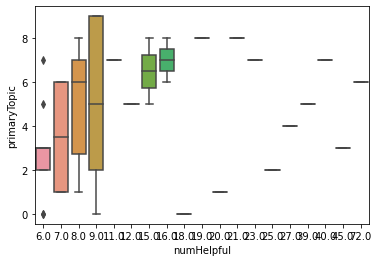

In [32]:
sns.boxplot(x="numHelpful", y="primaryTopic",  data=topics_df[(topics_df['numHelpful'] > 5) & (topics_df['numHelpful'] < 100)]);

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling